In [1]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np
import os
import cv2

Populating the interactive namespace from numpy and matplotlib


# Solutions to exercises in course "Image and Video Processing" by Prof. Guillermo Sapiro, Duke University

## Week 2 outline:
1. Basic implementation of JPEG using DCT, FFT and quantization
2. JPEG for color images.

# My notes on image compression


## How does it work?
* In block-transform coding, a reversible linear transform is used to map each black of an image into transform coefficients. 
* The coefficients with small magnitudes are then quantized or discarded completely with little image distortion.
* The processed image is then transformed back to the spatial domain.
* One can use the discrete Fourier trasform (DFT), discrete cosine transform (DCT), Walsh-Hadamard transform (WHT) or Karhunen-Loeve transform (KLT), for example.


## Why DCT for image compression?
* DCT belongs to the so-called block-transform coding compression technique.
* DCT has higher information packing ability than DFT or WHT. 
* KHT is superior to DCT in the information packing sense, but it is more demanding computationally. 
* DCT provides a good compromise between the information packing ability and computational complexity.
* DCT minimizes blocking artifacts due to boundary discontinuities  present in the DFT
* Wikipedia: The use of cosine rather than sine functions is critical for compression, since it turns out (as described below) that fewer cosine functions are needed to approximate a typical signal, whereas for differential equations the cosines express a particular choice of boundary conditions.

# 1. Basic implementation of JPEG - Grey image

**TASK**:  Do a basic implementation of JPEG:
- Divide the image into non-overlapping 8x8 blocks. Compute the DCT (discrete cosine transform) of each block. 
- Quantize each block. You can do this using the tables in the video or simply divide each coefficient by N, round the result to the nearest integer, and multiply back by N. Try for different values of N.
- You can also try preserving the 8 largest coefficients (out of the total of 8x8=64), and simply rounding them to the closest integer.
- Visualize the results after inverting the quantization and the DCT.
- Repeat the above but instead of using the DCT, use the FFT (Fast Fourier Transform).
- Repeat the above JPEG-type compression but don’t use any transform, simply perform quantization on the original image.

### 1.0 Read data

> Read out original image

dtype('uint8')

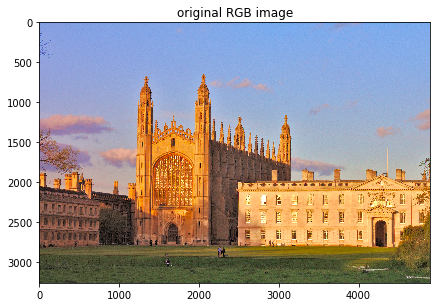

In [18]:
image = plt.imread('kings.tif')
plt.figure(figsize=(7,7))
plt.title('original RGB image')
plt.imshow(image)
image.dtype

In [19]:
np.unique(image).shape

(256,)

> Convert original RGB image to grayscale image

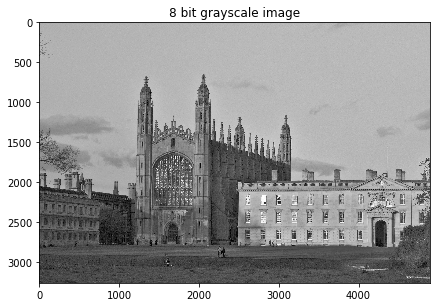

In [20]:
def rgb2gray(rgb_image):
    """
    a function converting grey to rgb
    """
    image_8bit = np.round(np.sum(rgb_image * np.array([0.114, 0.587, 0.299]), axis=-1)).astype('uint8')
    plt.figure(figsize=(7,7))
    plt.imshow(image_8bit , cmap='gray')
    plt.title('8 bit grayscale image')
    return image_8bit

gray_image = rgb2gray(image)

In [21]:
np.unique(gray_image).shape

(256,)

### 1.1 and 1.2: DCT and FFT of 8x8 blocks
**TASK**: Divide the image into non-overlapping 8x8 blocks and compute the DCT  and the FFT of each block

**MY NOTES:** 
* Why 8x8 blocks?
* Small block - faster, more correlation btween neightboring pixels
* Large block - slower, but the compression is better in smooth regions
* 8x8 is a standard size 

> Make sure the image dimensions are modulo 8

In [22]:
remainder0 = gray_image.shape[0] % 8
remainder1 = gray_image.shape[1] % 8

print(gray_image.shape[0] % 8)
print(gray_image.shape[1] % 8)

gray_image_mod8 = gray_image.copy()[:-remainder0,:-remainder1]

print(gray_image_mod8.shape[0] % 8)
print(gray_image_mod8.shape[1] % 8)

3
1
0
0


> Define discrete cosine transforms

In [23]:
from scipy.fftpack import dct, idct

def dct2(block):
    """
    define discrete cosine transform
    """
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    """
    define inverse discrete cosine transform
    """
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

> Compute forward DCT of the image

In [24]:
from skimage.util.shape import view_as_blocks
import copy

#convert to float64 to avoid issues while doing in-place DCT & IDCT computations
gray_image_mod8 = gray_image_mod8.astype('float64')
#
#initialise DCT of the gray image
image_dct = gray_image_mod8.copy()
#
#view the initialised image in blocks (it is still the original grayscale image!)
image_dct_blocks = view_as_blocks(image_dct,(8,8))
#
#compute DCT for each block (we operate with the blocks' view here)
for ii in range(0,gray_image_mod8.shape[0]//8):
    for kk in range(0,gray_image_mod8.shape[1]//8):
        image_dct_blocks[ii,kk,:,:] = dct2(image_dct_blocks[ii,kk,:,:])
        

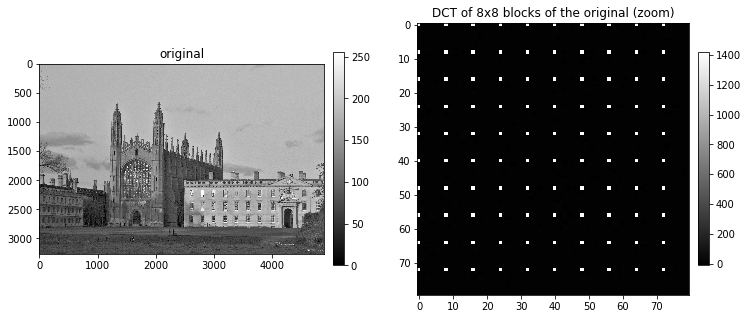

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axs
im1=ax1.imshow(gray_image_mod8, cmap='gray')
ax1.set_title('original')
im2=ax2.imshow(image_dct[0:80,0:80], cmap='gray')
ax2.set_title('DCT of 8x8 blocks of the original (zoom)')
plt.colorbar(im1,ax=ax1,fraction=0.035, pad=0.03)
plt.colorbar(im2,ax=ax2,fraction=0.035, pad=0.03)

> Compute forward FFT of the image

In [26]:
from numpy.fft import fft2
import copy

#
#initialise FFT of the gray image
image_fft = gray_image_mod8.copy()
#
#view the initialised image in blocks (it is still the original grayscale image!)
image_fft_blocks = view_as_blocks(image_fft,(8,8))
#
#compute FFT for each block (we operate with the blocks' view here, 
for ii in range(0,gray_image_mod8.shape[0]//8):
    for kk in range(0,gray_image_mod8.shape[1]//8):
        image_fft_blocks[ii,kk,:,:] = fft2(image_fft_blocks[ii,kk,:,:])
        

/Users/Pavel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


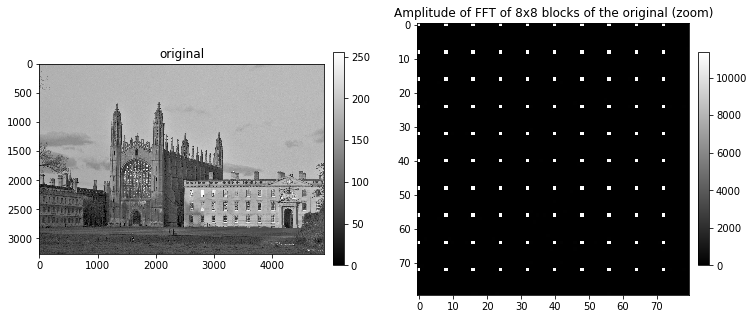

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axs
im1=ax1.imshow(gray_image_mod8, cmap='gray')
ax1.set_title('original')
im2=ax2.imshow(np.abs(image_fft[0:80,0:80]), cmap='gray')
ax2.set_title('Amplitude of FFT of 8x8 blocks of the original (zoom)')
plt.colorbar(im1,ax=ax1,fraction=0.035, pad=0.03)
plt.colorbar(im2,ax=ax2,fraction=0.035, pad=0.03)

### 1.3 Quantization

**TASK**: Quantize each block. You can do this using the tables in the video or simply divide each coefficient by N, round the result to the nearest integer, and multiply back by N. Try for different values of N.

> We try two N's for the quantization: 2 and 10.

In [29]:
image_dct_quantized_2 = image_dct.copy()
image_dct_quantized_10 = image_dct.copy()
image_dct_quantized_2 = (image_dct_quantized_2[:,:]//2)*2
image_dct_quantized_10 = (image_dct_quantized_10[:,:]//10)*10

### 1.4 Masking

**TASK**: You can also try preserving the 8 largest coefficients (out of the total of 8x8=64), and simply rounding them to the closest integer.

> Compute masks to keep 1 and 8 largest DCT coefficients only (no quantization)

In [36]:
def indices_of_first_maxima(array, num_maxima):
    """
    find indices of the first N maxima
    """
    # to maintain the sorted nature across the first num_maxima elements
    idx = np.argpartition(-array.ravel(),range(num_maxima))[:num_maxima]
    # convert idx, the array of flat indices, into a tuple of coordinate arrays.
    return np.column_stack(np.unravel_index(idx, array.shape))

In [37]:
numcoeff_to_keep_1 = 1
numcoeff_to_keep_8 = 8

#initialise the masked DCT image and view it as 8x8 blocks
image_dct_masked_1 = image_dct.copy()
image_dct_masked_1_blocks = view_as_blocks(image_dct_masked_1,(8,8))

image_dct_masked_8 = image_dct.copy()
image_dct_masked_8_blocks = view_as_blocks(image_dct_masked_8,(8,8))

#initialise the mask and view it as 8x8 blocks
mask_1 = np.zeros(image_dct_masked_1.shape)
mask_1_blocks = view_as_blocks(mask_1,(8,8))
mask_8 = np.zeros(image_dct_masked_8.shape)
mask_8_blocks = view_as_blocks(mask_8,(8,8))

#
#compute the mask
for ii in range(0,gray_image_mod8.shape[0]//8):
    for kk in range(0,gray_image_mod8.shape[1]//8):
        #
        idx_1 = indices_of_first_maxima(image_dct_masked_1_blocks[ii,kk,:,:], numcoeff_to_keep_1)
        idx_8 = indices_of_first_maxima(image_dct_masked_8_blocks[ii,kk,:,:], numcoeff_to_keep_8)
        for mm in range(0,len(idx_1)):
            mask_1_blocks[ii,kk,idx_1[mm][0],idx_1[mm][1]] = 1
        for mm in range(0,len(idx_8)):
            mask_8_blocks[ii,kk,idx_8[mm][0],idx_8[mm][1]] = 1

#apply the mask
image_dct_masked_1 = np.round(image_dct_masked_1 * mask_1)
image_dct_masked_8 = np.round(image_dct_masked_8 * mask_8)

> Apply masks to FFT data

In [38]:
# initialize masked FFT images
image_fft_masked_1 = image_dct.copy()
image_fft_masked_8 = image_dct.copy()

#apply the mask
image_fft_masked_1 = np.round(image_fft_masked_1 * mask_1)
image_fft_masked_8 = np.round(image_fft_masked_8 * mask_8)

### 1.5 Compute inverse DCT and inverse FFT

In [39]:
# initialise IDCT images 
image_idct_quantized_2 = image_dct_quantized_2.copy()
image_idct_quantized_10 = image_dct_quantized_10.copy()
image_idct_masked_1 = image_dct_masked_1.copy()
image_idct_masked_8 = image_dct_masked_8.copy()
#
# and view them as 8x8 blocks
image_idct_quantized_2_blocks = view_as_blocks(image_idct_quantized_2,(8,8))
image_idct_quantized_10_blocks = view_as_blocks(image_idct_quantized_10,(8,8))
image_idct_masked_1_blocks = view_as_blocks(image_idct_masked_1,(8,8))
image_idct_masked_8_blocks = view_as_blocks(image_idct_masked_8,(8,8))
#
# compute IDCT for each block (we operate with the blocks' view here) 
for ii in range(0,gray_image_mod8.shape[0]//8):
    for kk in range(0,gray_image_mod8.shape[1]//8):
        image_idct_masked_1_blocks[ii,kk,:,:] = idct2(image_idct_masked_1_blocks[ii,kk,:,:])
        image_idct_masked_8_blocks[ii,kk,:,:] = idct2(image_idct_masked_8_blocks[ii,kk,:,:])
        image_idct_quantized_2_blocks[ii,kk,:,:] = idct2(image_idct_quantized_2_blocks[ii,kk,:,:])
        image_idct_quantized_10_blocks[ii,kk,:,:] = idct2(image_idct_quantized_10_blocks[ii,kk,:,:])

In [40]:
from numpy.fft import ifft2

# initialise IFFT images
image_ifft_masked_1 = image_fft_masked_1.copy()
image_ifft_masked_8 = image_fft_masked_8.copy()
#
# view them as 8x8 blocks
image_ifft_masked_1_blocks = view_as_blocks(image_ifft_masked_1,(8,8))
image_ifft_masked_8_blocks = view_as_blocks(image_ifft_masked_8,(8,8))

#
# compute IFFT for each block (we operate with the blocks' view here) 
for ii in range(0,gray_image_mod8.shape[0]//8):
    for kk in range(0,gray_image_mod8.shape[1]//8):
        image_ifft_masked_1_blocks[ii,kk,:,:] = ifft2(image_ifft_masked_1_blocks[ii,kk,:,:])
        image_ifft_masked_8_blocks[ii,kk,:,:] = ifft2(image_ifft_masked_8_blocks[ii,kk,:,:])


/Users/Pavel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/Users/Pavel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


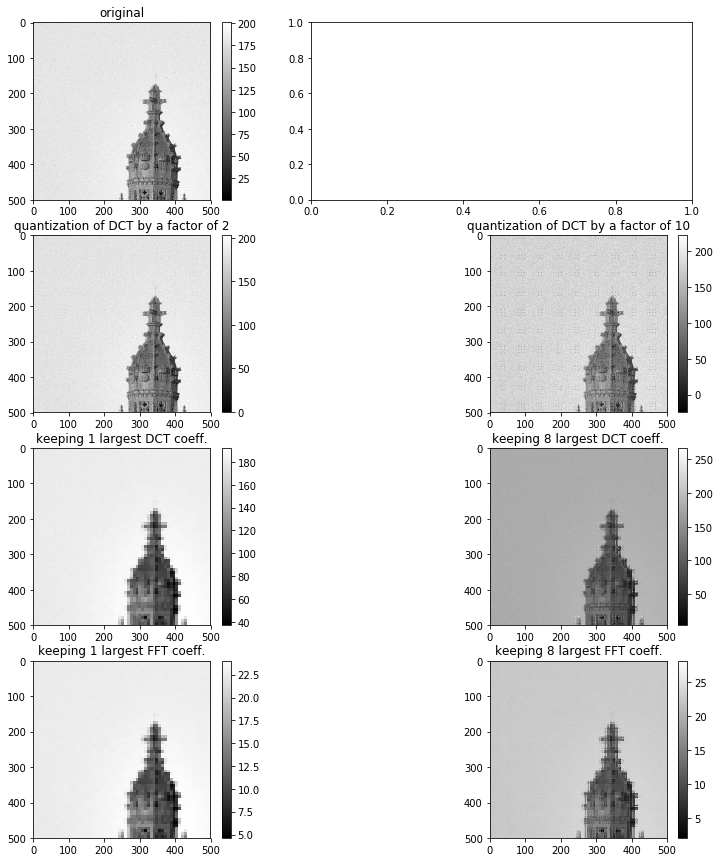

In [42]:
# plot compressed images
fig, axs = plt.subplots(4, 2, figsize=(15,15))
im1=axs[0,0].imshow(gray_image_mod8[500:1000,1000:1500] , cmap='gray')
axs[0,0].set_title('original')
im2=axs[1,0].imshow(image_idct_quantized_2[500:1000,1000:1500], cmap='gray')
axs[1,0].set_title('quantization of DCT by a factor of 2')
im3=axs[1,1].imshow(image_idct_quantized_10[500:1000,1000:1500], cmap='gray')
axs[1,1].set_title('quantization of DCT by a factor of 10')
im4=axs[2,0].imshow(image_idct_masked_1[500:1000,1000:1500], cmap='gray')
axs[2,0].set_title('keeping 1 largest DCT coeff.')
im5=axs[2,1].imshow(image_idct_masked_8[500:1000,1000:1500], cmap='gray')
axs[2,1].set_title('keeping 8 largest DCT coeff.')
im6=axs[3,0].imshow(image_ifft_masked_1[500:1000,1000:1500], cmap='gray')
axs[3,0].set_title('keeping 1 largest FFT coeff.')
im7=axs[3,1].imshow(image_ifft_masked_8[500:1000,1000:1500], cmap='gray')
axs[3,1].set_title('keeping 8 largest FFT coeff.')
plt.colorbar(im1,ax=axs[0,0],fraction=0.035, pad=0.03)
plt.colorbar(im2,ax=axs[1,0],fraction=0.035, pad=0.03)
plt.colorbar(im3,ax=axs[1,1],fraction=0.035, pad=0.03)
plt.colorbar(im4,ax=axs[2,0],fraction=0.035, pad=0.03)
plt.colorbar(im5,ax=axs[2,1],fraction=0.035, pad=0.03)
plt.colorbar(im6,ax=axs[3,0],fraction=0.035, pad=0.03)
plt.colorbar(im7,ax=axs[3,1],fraction=0.035, pad=0.03)